## Analyzing VELMA simulated runoff output

This notebook examines the observed runoff at the Ellsworth Creek gauge (found [here](https://fortress.wa.gov/ecy/eap/flows/station.asp?sta=24M050&historical=true#block2) and [here](https://apps.ecology.wa.gov/ContinuousFlowAndWQ/StationDetails?sta=24M050)) and compares it to the runoff simulated in VELMA. The stream gauge data comes with quality tags that describe how far each daily measurement deviates from a rating table for the creek. To determine if these outlier days are causing the discrepancy between simulated and observed runoff, days with very high (>2x rating table) or very low (&lt;1/2x) flows are removed and NSE is computed again.

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 110

In [3]:
# Import and format observed data (2003-2007 runoff)

input_dir = config.velma_data
results_dir = config.data_path.parents[0] / 'results' / 'calibration' / 'subzero_water_balance' / 'ellsworth_baseline_03_07_21_19'

runoff_path = input_dir / 'runoff' / 'ellsworth_Q_2003_2007_dummy.csv'
runoff_start = pd.to_datetime('01-01-2003')
runoff_end = pd.to_datetime('12-31-2007')
nse_start = pd.to_datetime('01-01-2004')
nse_end = pd.to_datetime('12-31-2007')

runoff_obs = pd.read_csv(runoff_path, names=['runoff_obs'])
runoff_obs.index = pd.date_range(runoff_start, runoff_end)
runoff_obs['doy'], runoff_obs['year'] = runoff_obs.index.dayofyear, runoff_obs.index.year
runoff_obs = runoff_obs[(runoff_obs.index >= nse_start) & (runoff_obs.index <= nse_end)]

flow_path = input_dir.parents[0] / 'hydrology' / 'ellsworth' / 'wa_ecy_gauge' / 'streamflow' / 'ells_streamflow_2003_2008.csv'
quality = pd.read_csv(flow_path, usecols=['Date', 'Quality'], parse_dates=True, index_col=0)
quality = quality[(quality.index >= nse_start) & (quality.index <= nse_end)]

precip_path = input_dir / 'precip' / 'PRISM_gauge_avg_ppt_2003_2019.csv'
forcing_start = pd.to_datetime('01-01-2003')
forcing_end = pd.to_datetime('12-31-2019')                     
precip = pd.read_csv(precip_path, names=['precip'])
precip.index = pd.date_range(forcing_start, forcing_end)
precip['doy'], precip['year'] = precip.index.dayofyear, precip.index.year
precip = precip[(precip.index >= nse_start) & (precip.index <= nse_end)]

temp_path = input_dir / 'temp' / 'ellsworth_temp_2003_2019.csv'
temp = pd.read_csv(temp_path, names=['temp'])
temp.index = pd.date_range(forcing_start, forcing_end)
temp['doy'], temp['year'] = temp.index.dayofyear, temp.index.year
temp = temp[(temp.index >= nse_start) & (temp.index <= nse_end)]

# Import VELMA outputs
velma_results = pd.read_csv(results_dir / 'DailyResults.csv')

# Format datetime of results
jday_pad = velma_results['Day'].apply(lambda x: str(x).zfill(3))
str_year = velma_results['Year'].apply(lambda x: str(x))
velma_results['year_jday'] = str_year + jday_pad
velma_results.index = pd.to_datetime(velma_results['year_jday'], format='%Y%j')
velma_results = velma_results[(velma_results.index >= nse_start) & 
                              (velma_results.index <= nse_end)]

## Metrics

Calculate mean-squared error, root mean-squared error, and R-squared (equal to NSE) of simulated and observed runoff

In [4]:
# velma_results['Runoff_All(mm/day)_Delineated_Average'].sum() / runoff_obs['runoff_obs'].sum()
sim_mse = mean_squared_error(runoff_obs['runoff_obs'], velma_results['Runoff_All(mm/day)_Delineated_Average'])
sim_mae = mean_absolute_error(runoff_obs['runoff_obs'], velma_results['Runoff_All(mm/day)_Delineated_Average'])
display('MSE', sim_mse)
display('MAE', sim_mae)
display('RMSE', np.sqrt(sim_mse))

display('R2', r2_score(runoff_obs['runoff_obs'], velma_results['Runoff_All(mm/day)_Delineated_Average']))

'MSE'

30.389150601639635

'MAE'

2.504075918937619

'RMSE'

5.512635540432511

'R2'

0.5956554140422972

## Plotting

In [5]:
# Group measurements by year
runoff_sim_yearly = pd.pivot_table(velma_results, index=['Day'], columns=['Year'],
                                   values=['Runoff_All(mm/day)_Delineated_Average'])
runoff_obs_yearly = pd.pivot_table(runoff_obs, index=['doy'], columns=['year'], values=['runoff_obs'])
precip_yearly = pd.pivot_table(precip, index=['doy'], columns=['year'], values=['precip'])

#### Observed vs. VELMA simulated runoff

VELMA simulated runoff consistently underpredicts the observed runoff during flow peaks. This could be sensor error or may be the flashiness of the stream. There is also a period of very low observed runoff during 2006 that looks fishy. 

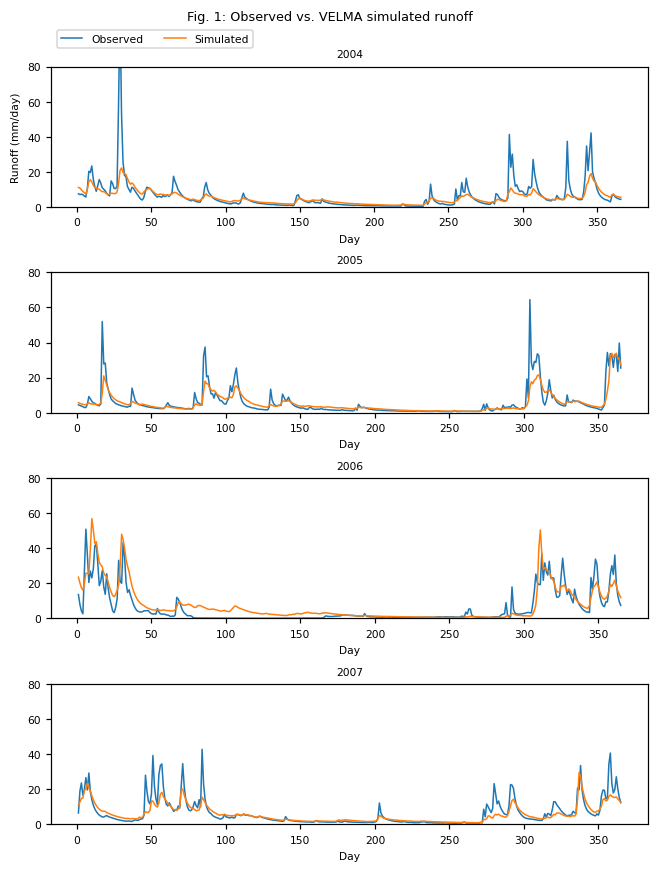

In [6]:
# Observed vs. VELMA simulated runoff
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 8))
for col, year in enumerate(years):
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 80])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 1: Observed vs. VELMA simulated runoff')
plt.tight_layout()

#### Observed vs. VELMA simulated runoff (with precipitation)

Including the precipitation suggests that the low flow values during 2006 are not from a drought but may instead be sensor error, because the precipitation during 2006 is comparable to the other years and shouldn't be causing such a low measurement period.

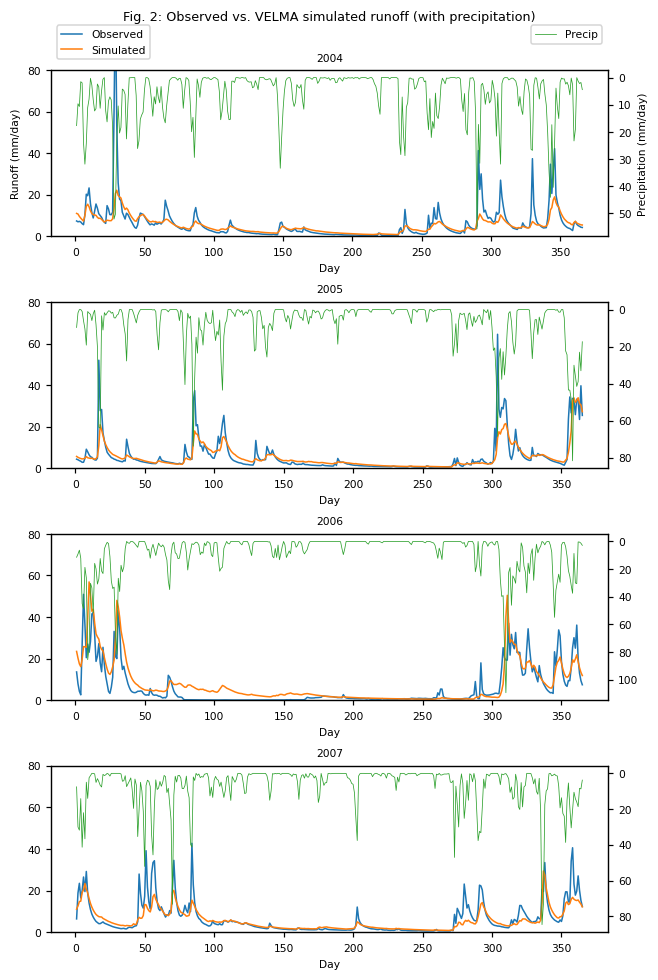

In [7]:
# Runoff and precip
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    precip_yearly.iloc[:, col].plot(ax=ax2, label='Precip', linewidth=0.5, color='tab:green')
    if col == 0:
        ax2.set_ylabel('Precipitation (mm/day)')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([0, 80])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 2: Observed vs. VELMA simulated runoff (with precipitation)')
plt.tight_layout()

#### Observed vs. VELMA simulated runoff (with precipitation and quality flags for runoff measurements)

Here we can add in the quality flags for the runoff data. Each day has a flag, so we'll just include the ones that are the most unreliable. 

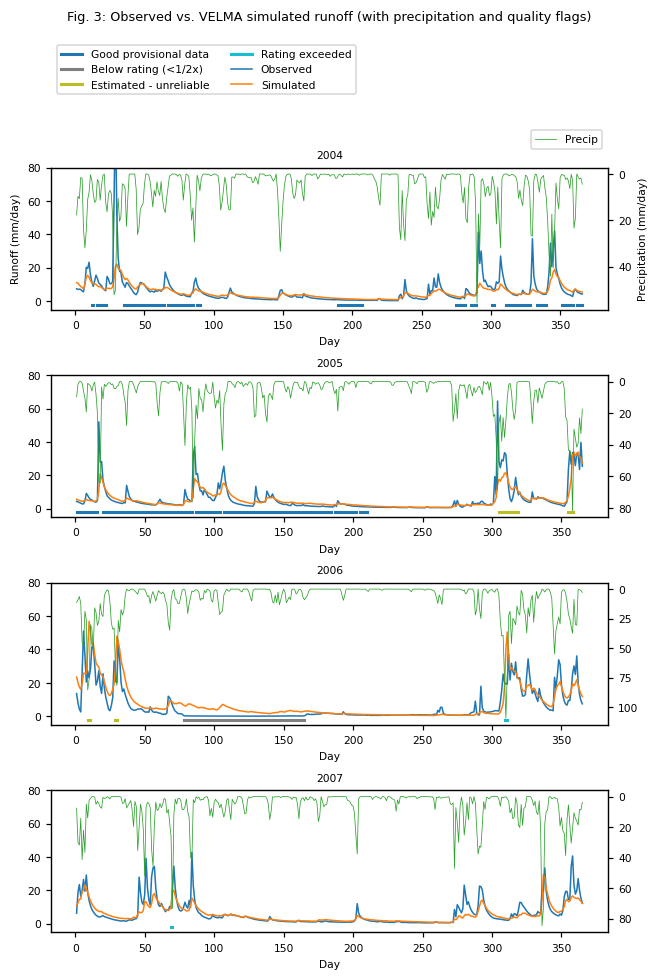

In [8]:
# Add quality scores below plot

colors = sns.color_palette('tab10', 10)

quality_edit = quality.copy()

quality_edit['doy'], quality_edit['year'] = quality_edit.index.dayofyear, quality_edit.index.year
quality_edit_yearly = pd.pivot_table(quality_edit, index=['doy'], columns=['year'], values=['Quality'])
quality2 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                        [-2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
quality3 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                        [np.nan, -2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
quality8 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                       [np.nan, np.nan, -2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
quality10 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                        [np.nan, np.nan, np.nan, -2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
quality50 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                        [np.nan, np.nan, np.nan, np.nan, -2, np.nan, np.nan, np.nan, np.nan, np.nan])
quality77 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                        [np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan, np.nan, np.nan, np.nan])
quality160 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan, np.nan, np.nan])
quality161 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan, np.nan])
quality179 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan])
quality254 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2])

years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    precip_yearly.iloc[:, col].plot(ax=ax2, label='Precip', color='tab:green', linewidth=0.5)
    if col == 0:
        ax2.set_ylabel('Precipitation (mm/day)')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    quality2.iloc[:, col].plot(ax=axes[col], color=colors[0], linewidth=2, label='Good provisional data')
#     quality3.iloc[:, col].plot(ax=axes[col], color=colors[1], linewidth=2, label='Good provisional data - edited')
#     quality8.iloc[:, col].plot(ax=axes[col], color=colors[2], linewidth=2, label='Below rating')
#     quality10.iloc[:, col].plot(ax=axes[col], color=colors[3], linewidth=2, label='Above rating (<2x)')
#     quality50.iloc[:, col].plot(ax=axes[col], color=colors[4], linewidth=2, label='Estimated')
#     quality77.iloc[:, col].plot(ax=axes[col], color=colors[5], linewidth=2, label='Estimated from other station')
#     quality160.iloc[:, col].plot(ax=axes[col], color=colors[6], linewidth=2, label='Above rating (>2x)')
    quality161.iloc[:, col].plot(ax=axes[col], color=colors[7], linewidth=2, label='Below rating (<1/2x)')
    quality179.iloc[:, col].plot(ax=axes[col], color=colors[8], linewidth=2, label='Estimated - unreliable')
    quality254.iloc[:, col].plot(ax=axes[col], color=colors[9], linewidth=2, label='Rating exceeded')
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([-5, 80])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.9), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
fig.suptitle('Fig. 3: Observed vs. VELMA simulated runoff (with precipitation and quality flags)')
plt.tight_layout()
# plt.savefig('baseline_runoffs_qaflags.png', dpi=300)

Adding quality flags unreliable and extreme measurements, we can see that many of these are the peaks and troughs where VELMA performs the worst. This doesn't necessarily mean there is an error with the stream gauge, just flags the values as extra-ordinary. Does beg the question - is this the natural flashiness of Ellsworth that the rating table just didn't capture? Or is this the result of instrument error?

### Removing unreliable runoff values and calculating Nash-Sutcliffe

What if we just removed the values that are the least reliable from computing Nash-Sutcliffe? The following quality flags were removed: "Exceeded rating table (>2x)" (160), "Below rating table (<1/2x)" (161), "Estimated - unreliable" (179).

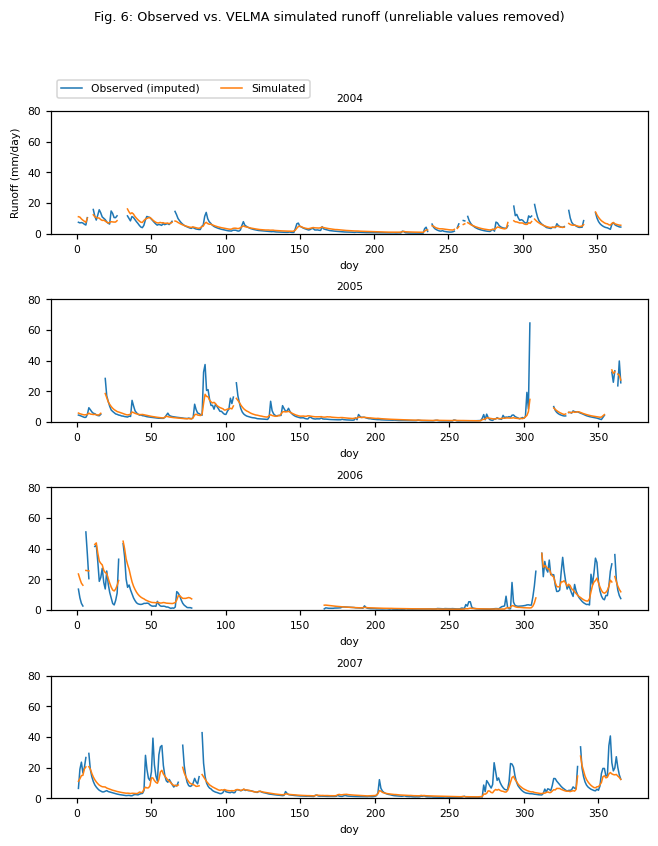

In [9]:
runoff_sim = velma_results['Runoff_All(mm/day)_Delineated_Average']
df = pd.concat([runoff_sim, runoff_obs, quality], axis=1)
df_edited = df.drop(df[(df['Quality'] == 50) | (df['Quality'] == 160) | (df['Quality'] == 161) | (df['Quality'] == 179)].index)
df_edited = df.drop(df[(df['Quality'] == 160) | (df['Quality'] == 161) | (df['Quality'] == 179)].index)
df_edited = df.drop(df[(df['Quality'] == 160) | (df['Quality'] == 161) | (df['Quality'] == 179) | (df['Quality'] == 254)].index)

# 2003-2007 runoff
sim_yearly = pd.pivot_table(df_edited[['Runoff_All(mm/day)_Delineated_Average', 'doy', 'year']], 
                            index=['doy'], 
                            columns=['year'], 
                            values=['Runoff_All(mm/day)_Delineated_Average'])

obs_yearly = pd.pivot_table(df_edited[['runoff_obs', 'doy', 'year']], 
                            index=['doy'], 
                            columns=['year'], 
                            values=['runoff_obs'])

years = obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 8))
for col, year in enumerate(years):
    obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed (imputed)', linewidth=1)
    sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 80])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
fig.suptitle('Fig. 6: Observed vs. VELMA simulated runoff (unreliable values removed)')
axes[0].set_ylabel('Runoff (mm/day)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Improvement metrics

In [10]:
# Computing Nash-Sutcliffe
def NS(s, o):
    """
        Nash Sutcliffe efficiency coefficient
        input:
        s: simulated
        o: observed
        output:
        ns: Nash Sutcliffe efficient coefficient
        """
    # s,o = filter_nan(s,o)
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)


df_edited_04_07 = df_edited[(df_edited.index >= pd.to_datetime('2004-01-01'))]

print('NS (2004): {} --> {}'.format(np.round(NS(runoff_sim_yearly.iloc[:, 0], runoff_obs_yearly.iloc[:, 0]), 3),
                                    np.round(NS(sim_yearly.iloc[:, 0], obs_yearly.iloc[:, 0]), 3)))
print('NS (2005): {} --> {}'.format(np.round(NS(runoff_sim_yearly.iloc[:, 1], runoff_obs_yearly.iloc[:, 1]), 3),
                                    np.round(NS(sim_yearly.iloc[:, 1], obs_yearly.iloc[:, 1]), 3)))
print('NS (2006): {} --> {}'.format(np.round(NS(runoff_sim_yearly.iloc[:, 2], runoff_obs_yearly.iloc[:, 2]), 3),
                                    np.round(NS(sim_yearly.iloc[:, 2], obs_yearly.iloc[:, 2]), 3)))
print('NS (2007): {} --> {}'.format(np.round(NS(runoff_sim_yearly.iloc[:, 3], runoff_obs_yearly.iloc[:, 3]), 3),
                                    np.round(NS(sim_yearly.iloc[:, 3], obs_yearly.iloc[:, 3]), 3)))
print('NS (2004-2007): {} --> {}'.format(np.round(NS(velma_results['Runoff_All(mm/day)_Delineated_Average'], runoff_obs['runoff_obs']), 3),
                                         np.round(NS(df_edited_04_07['Runoff_All(mm/day)_Delineated_Average'], df_edited_04_07['runoff_obs']), 3)))

NS (2004): 0.424 --> 0.743
NS (2005): 0.673 --> 0.679
NS (2006): 0.646 --> 0.77
NS (2007): 0.675 --> 0.671
NS (2004-2007): 0.596 --> 0.724


#### Export runoff with quality flagged values as NaN

In [11]:
# runoff_quality = runoff_obs.merge(quality, left_index=True, right_index=True, how='left')
# remove = runoff_quality.loc[(runoff_quality['Quality'] == 160) | (runoff_quality['Quality'] == 161) | (runoff_quality['Quality'] == 179)].index
# runoff_quality.loc[remove,'runoff_obs'] = 'NaN'

In [12]:
# outfile = config.velma_data / 'runoff' / 'ellsworth_Q_2003_2007_dummy_flagged.csv'
# runoff_quality['runoff_obs'].to_csv(outfile, index=False, header=False)